In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

print('Tensorflow version: {}'.format(tf.__version__))

Tensorflow version: 2.16.1


In [8]:
# 讀取數據
file_path = 'tsmc_prices_complete_datetime_2010-2023.csv'  # 確保你的數據集準備好
df = pd.read_csv(file_path)
data = df[['open', 'high', 'low', 'close']].values  # 包含多個特徵

# 標準化數據
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# 創建數據集
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :]
        dataX.append(a)
        dataY.append(dataset[i + time_step, -1])  # 使用'close'作為目標變量
    return np.array(dataX), np.array(dataY)

# 參數
time_step = 30
train_size = int(len(data_scaled) * 0.8)
val_size = int(len(data_scaled) * 0.1)
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[0:train_size, :]
val_data = data_scaled[train_size:train_size+val_size, :]
test_data = data_scaled[train_size+val_size:, :]

x_train, y_train = create_dataset(train_data, time_step)
x_val, y_val = create_dataset(val_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

# 調整輸入形狀以符合模型需求
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2])
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], x_val.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2])

print('x_train.shape:', x_train.shape)
print('y_train.shape:', y_train.shape)
print('x_val.shape:', x_val.shape)
print('y_val.shape:', y_val.shape)
print('x_test.shape:', x_test.shape)
print('y_test.shape:', y_test.shape)


x_train.shape: (2712, 30, 4)
y_train.shape: (2712,)
x_val.shape: (311, 30, 4)
y_val.shape: (311,)
x_test.shape: (313, 30, 4)
y_test.shape: (313,)


In [9]:
# Transformer Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

In [10]:
# Model Definition
inputs = Input(shape=(x_train.shape[1], x_train.shape[2]))
x = transformer_encoder(inputs, head_size=256, num_heads=4, ff_dim=4, dropout=0.1)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
outputs = Dense(1, activation="linear")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="mean_squared_error")

# Model Summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 30, 4)     │          8 │ input_layer[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 4)     │     19,460 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 30, 4)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 30, 4)     │          0 │ dropout_1[0][0],  │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 4)     │          8 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 30, 4)     │         20 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 30, 4)     │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 30, 4)     │         20 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 30, 4)     │          0 │ dense_1[0][0],    │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 4)         │          0 │ add_1[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 4)         │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 20)        │        100 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         21 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,637 (76.71 KB)

 Trainable params: 19,637 (76.71 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train the model
# model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=64, verbose=1)

from keras.callbacks import EarlyStopping


history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=200,
                    validation_data=(x_val, y_val),
                    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])


Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0201 - val_loss: 0.0584
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0054 - val_loss: 0.0372
Epoch 3/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - val_loss: 0.0233
Epoch 4/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - val_loss: 0.0130
Epoch 5/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - val_loss: 0.0110
Epoch 6/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - val_loss: 0.0076
Epoch 7/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.9622e-04 - val_loss: 0.0050
Epoch 8/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.2763e-04 - val_loss: 0.0057
Epoch 9/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 - val_loss: 0.0041
Epoch 10/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.0073e-04 - val_loss: 0.0048
Epoch 11/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.2548e-04 - val_loss: 0.0034
Epoch 12/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9m

In [13]:
# # Make predictions
# train_predict = model.predict(x_train)
# test_predict = model.predict(x_test)

# # Inverse transform predictions
# train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1)).flatten()
# test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1)).flatten()

# # Evaluate the model (Optional: Calculate RMSE or other metrics)
# train_rmse = math.sqrt(mean_squared_error(scaler.inverse_transform(y_train.reshape(-1, 1)).flatten(), train_predict))
# test_rmse = math.sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)).flatten(), test_predict))

# print(f"Train RMSE: {train_rmse}")
# print(f"Test RMSE: {test_rmse}")
#########################################

# Make predictions
train_predict = model.predict(x_train)
val_predict = model.predict(x_val)
test_predict = model.predict(x_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(np.concatenate([np.zeros((train_predict.shape[0], data_scaled.shape[1] - 1)), train_predict], axis=1))[:, -1]
val_predict = scaler.inverse_transform(np.concatenate([np.zeros((val_predict.shape[0], data_scaled.shape[1] - 1)), val_predict], axis=1))[:, -1]
test_predict = scaler.inverse_transform(np.concatenate([np.zeros((test_predict.shape[0], data_scaled.shape[1] - 1)), test_predict], axis=1))[:, -1]

# Inverse transform true values
y_train_true = scaler.inverse_transform(np.concatenate([np.zeros((y_train.shape[0], data_scaled.shape[1] - 1)), y_train.reshape(-1, 1)], axis=1))[:, -1]
y_val_true = scaler.inverse_transform(np.concatenate([np.zeros((y_val.shape[0], data_scaled.shape[1] - 1)), y_val.reshape(-1, 1)], axis=1))[:, -1]
y_test_true = scaler.inverse_transform(np.concatenate([np.zeros((y_test.shape[0], data_scaled.shape[1] - 1)), y_test.reshape(-1, 1)], axis=1))[:, -1]

# Evaluate the model (Calculate RMSE or other metrics)
train_rmse = math.sqrt(mean_squared_error(y_train_true, train_predict))
val_rmse = math.sqrt(mean_squared_error(y_val_true, val_predict))
test_rmse = math.sqrt(mean_squared_error(y_test_true, test_predict))

print(f"Train RMSE: {train_rmse}")
print(f"Validation RMSE: {val_rmse}")
print(f"Test RMSE: {test_rmse}")

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train RMSE: 16.649712992801533
Validation RMSE: 24.725725092618863
Test RMSE: 32.19490629481139


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


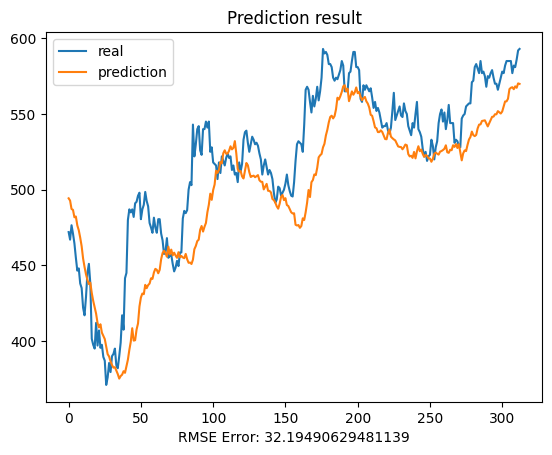

In [16]:
# Make predictions
y_predict = model.predict(x_test)

# Inverse transform true values and predictions
y_real = scaler.inverse_transform(np.concatenate([np.zeros((y_test.shape[0], data_scaled.shape[1] - 1)), y_test.reshape(-1, 1)], axis=1))[:, -1]
y_predict = scaler.inverse_transform(np.concatenate([np.zeros((y_predict.shape[0], data_scaled.shape[1] - 1)), y_predict], axis=1))[:, -1]

# Plot the results
plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')

# Calculate and display RMSE
rmse = np.sqrt(mean_squared_error(y_real, y_predict))
plt.xlabel('RMSE Error: {}'.format(rmse))
plt.legend()
plt.title('Prediction result')
plt.show()

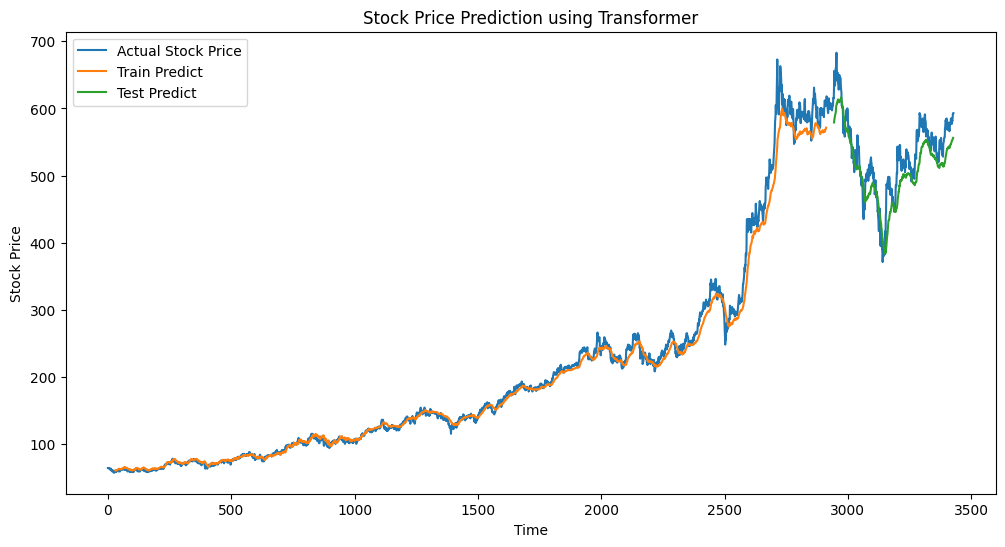

In [8]:
# Plotting the results
# Adjust the time_step offset for plotting
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(train_predict)+time_step, :] = train_predict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(time_step*2)+1:len(data_scaled)-1, :] = test_predict

# Plot baseline and predictions
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(data_scaled), label='Actual Stock Price')
plt.plot(trainPredictPlot, label='Train Predict')
plt.plot(testPredictPlot, label='Test Predict')
plt.title('Stock Price Prediction using Transformer')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [15]:
y_predict = model.predict(x_test)
y_real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

y_predict = scaler.inverse_transform(y_predict.reshape(-1, 1)).flatten()
# print('real: ', y_real.shape)


plt.figure(1)
plt.plot(y_real, label='real')
plt.plot(y_predict, label='prediction')
# plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real, y_predict)))
rmse = np.sqrt(mean_squared_error(y_real, y_predict))
plt.xlabel('RMSE Error: {}'.format(rmse))
plt.legend()
plt.title('Prediction result')
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)